In [2]:
!pip install eofs
!pip install netCDF4
!pip install xarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eofs: filename=eofs-1.4.0-py3-none-any.whl size=1100355 sha256=153999afcfdc57dd2f5e9bbe8bb759bdc4b2db83965940bfd1c71ad681c1ca47
  Stored in directory: /root/.cache/pip/wheels/3d/69/36/c8bd247900ab5ade980a418ac2faed41e08f5006f7c369282f
Successfully built eofs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from eofs.xarray import Eof

In [4]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [5]:
data_path = "/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/"

# path to save the netcdf file
path_output = data_path + 'outputs_ssp245_prediction_pattern2.nc'

# path to testing data (ssp245)
pathssp245_Y = 'outputs_ssp245.nc'
pathssp245_X = 'inputs_ssp245.nc'

In [6]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.6
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4

In [11]:
inputs

['/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/inputs_ssp126.nc',
 '/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/inputs_ssp245.nc',
 '/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/inputs_ssp370.nc',
 '/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/inputs_ssp370-lowNTCF.nc',
 '/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/inputs_ssp585.nc']

In [14]:
label=input.split('_')[1]

In [15]:
label

'emulator'

In [10]:
for input in inputs:
    label=input.split('_')[1][:-3]
    print(label)

emula
emula
emula
emula
emula


In [9]:
label

'emula'

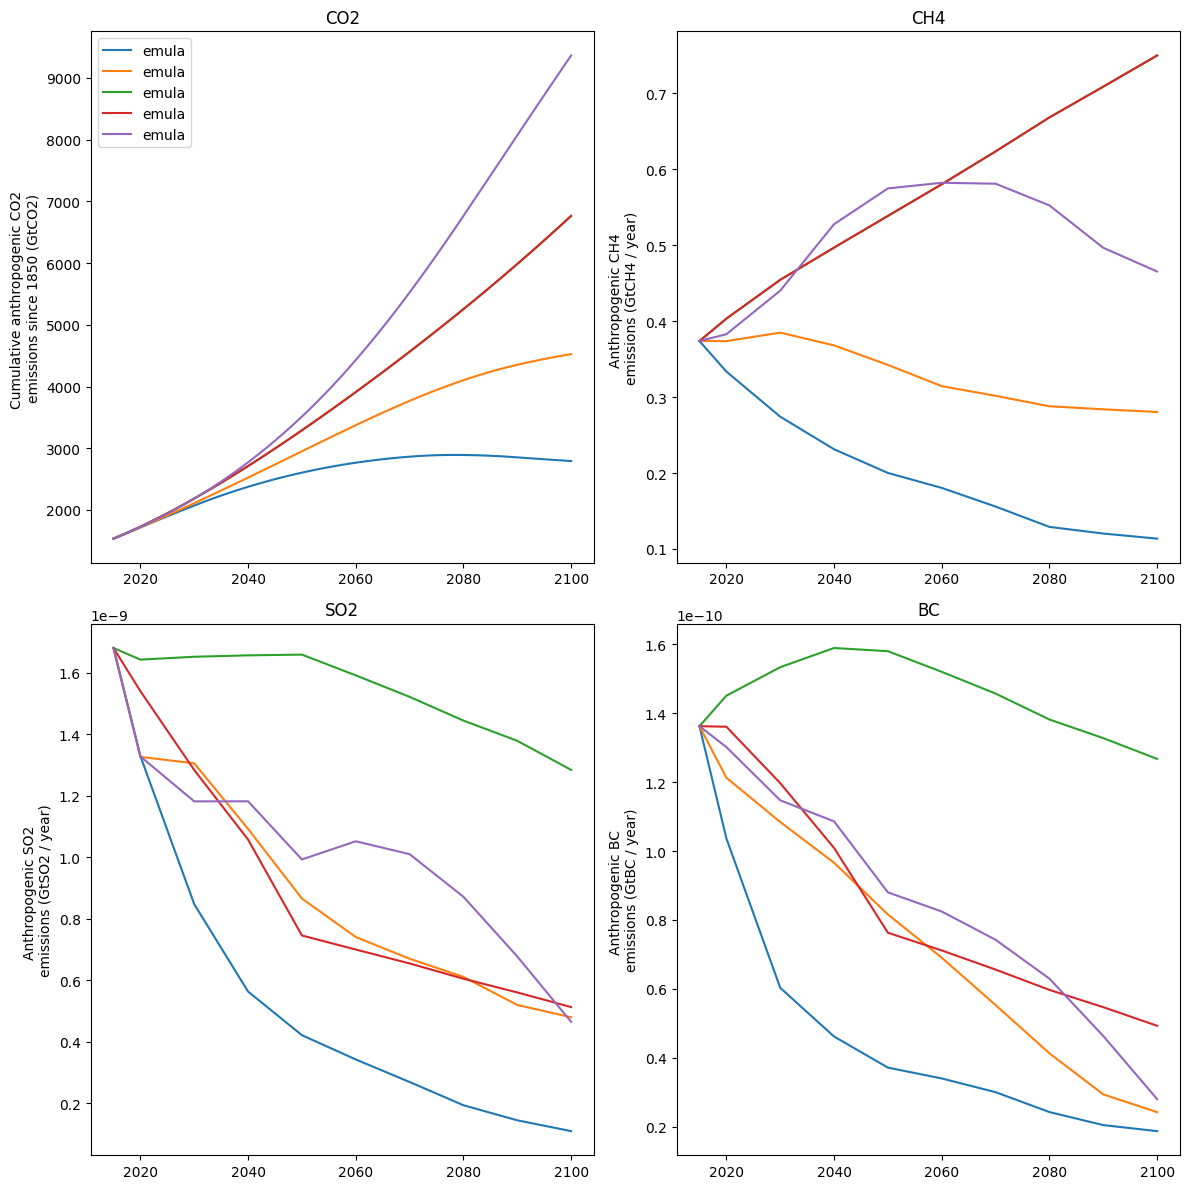

In [7]:
from glob import glob

inputs = glob(data_path + "inputs_s*.nc")
SECONDS_IN_YEAR = 60*60*24*365 #s

fig, axes = plt.subplots(2, 2, figsize=(12,12))

for input in inputs:
    label=input.split('_')[1][:-3]
    X = xr.open_dataset(input)
    x = range(2015, 2101)

    weights = np.cos(np.deg2rad(X.latitude))

    axes[0, 0].plot(x, X['CO2'].data, label=label)
    axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[0, 1].plot(x, X['CH4'].data, label=label)
    axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
    axes[1, 0].plot(x, X['SO2'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
    axes[1, 1].plot(x, X['BC'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

axes[0, 0].set_title('CO2')
axes[0, 1].set_title('CH4')
axes[1, 0].set_title('SO2')
axes[1, 1].set_title('BC')
axes[0, 0].legend()
plt.tight_layout()